In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import IPython.display

# Lista 6 (11 pkt.)

## Zadanie 1 (1 pkt.)

Wczytaj obrazek $\textit{miki.png}$

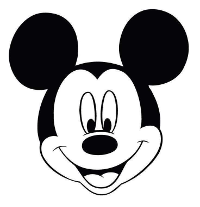

In [2]:
def dec2bin(dec_str,pad):
    return format(int(dec_str),'0'+str(pad)+'b')

img=Image.open('miki.png')
arr=np.array(img).ravel()
arr_bin=[dec2bin(d,pad='8') for d in arr]
bits=''.join(arr_bin)
img

i zaszyfruj go za pomocą DESa z kluczem:

In [3]:
key='0111101000001010110010000001010101111111100000000000101000110001'

stosując szyfrowanie blok po bloku, czyli tak jak na liście 3., tzn. w trybie ECB.

<img src="ECB_encryption.svg" width="1000" align="left"/>
<img src="ECB_decryption.svg" width="1000" align="left"/>

In [4]:
import DES_utils

Wyświetl zaszyfrowany obrazek.

In [5]:
subkeys = DES_utils.key_schedule(key)
blocks = DES_utils.split_message(bits)
encoded_blocks = [DES_utils.DES(b, subkeys) for b in blocks]
img_t = ''.join(encoded_blocks)

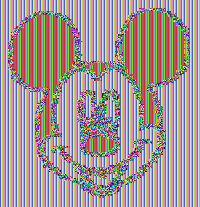

In [6]:
def split_img(img_bin,n):
    img_split=[]
    for i in range(0, len(img_bin), n):
        img_split.append(img_bin[i:i+n])
    return img_split

def bin2dec(bin_str):
    return int(bin_str, 2)

img=np.array([bin2dec(b) for b in split_img(img_t,8)]).reshape(np.array(img).shape)
Image.fromarray(np.uint8(np.array(img)))

Mimo zaszyfrowania łatwo rozpoznać co było na obrazku.

## Zadanie 2 (2 pkt.)

Zaimplementuj tryb szyfrowania CBC.

<img src="CBC_encryption.svg" width="1000" align="left"/>

In [7]:
def CBC(msg,key,iv):
    blocks = DES_utils.split_message(msg)
    subkeys = DES_utils.key_schedule(key)
    
    for i in range(len(blocks)):
        xor = DES_utils.xor(blocks[i], iv)
        ciphertext = DES_utils.DES(xor, subkeys)
        blocks[i] = ciphertext
        iv = ciphertext
        
    return ''.join(blocks)

In [8]:
#key to zmienna z poprzedniego zadania
iv='0011111111001100000111011100110100100101010100000111010001000110'
msg='1000110001101011011101110010100111101111101100111100001010100001011111110100000100100000111011001011000001011100110111101111110100000000100101011101110010000000110011011100000111000110011100111000010111111111011111000110001010101001101111110000010110011011'
print(CBC(msg,key,iv)=='1111101000110001101111001100101101011001101010001101010101100111011001100111010011001011100001001111011000001111110010011110011101010000101011010011011100011110011011001011100100011100011001011101110011110001110100010111001100100010111101011111101010111000')

True


Zaszyfruj obrazek z zadania 1. za pomocą DESa w trybie CBC, zaszyfrowany obrazek wyświetl i zobacz czy nadal widoczna jest na nim Myszka Miki.

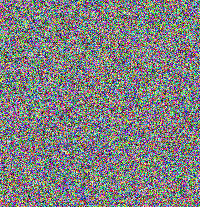

In [9]:
img_t = CBC(bits,key,iv)

img=np.array([bin2dec(b) for b in split_img(img_t,8)]).reshape(np.array(img).shape)
Image.fromarray(np.uint8(np.array(img)))

## Zadanie 3 (1 pkt.)

Zaimplementuj deszyfrację w trybi CBC. Zdeszyfruj zaszyfrowany w poprzednim zadaniu obrazek i sprawdź czy otrzymałeś pierwotny obrazek.

<img src="CBC_decryption.svg" width="1000" align="left"/>

In [10]:
def CBCde(msg,key,iv):
    blocks = DES_utils.split_message(msg)
    subkeys = list(reversed(DES_utils.key_schedule(key)))
    
    for i in range(len(blocks)):
        ciphertext = blocks[i]
        decrypted = DES_utils.DES(ciphertext, subkeys)
        plaintext = DES_utils.xor(decrypted, iv)
        iv = ciphertext
        blocks[i] = plaintext
        
    return ''.join(blocks)

In [11]:
img_dec = CBCde(img_t, key, iv)

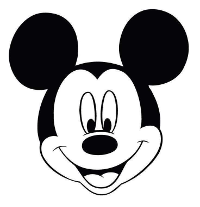

In [12]:
img=np.array([bin2dec(b) for b in split_img(img_dec,8)]).reshape(np.array(img).shape)
Image.fromarray(np.uint8(np.array(img)))

## Zadanie 4 (2 pkt.)

Zaimplementuj tryb OFB. W tym trybie zarówno szyfracja jak i deszyfracja odbywają się za pomocą dokładnie tego samego algorytmu.

<img src="OFB_encryption.svg" width="1000" align="left"/>
<img src="OFB_decryption.svg" width="1000" align="left"/>

In [13]:
def OFB(msg,key,iv):
    blocks = DES_utils.split_message(msg)
    subkeys = DES_utils.key_schedule(key)
    
    for i in range(len(blocks)):
        encrypted_iv = DES_utils.DES(iv, subkeys)
        ciphertext = DES_utils.xor(blocks[i], encrypted_iv)
        blocks[i] = ciphertext
        iv = encrypted_iv
        
    return ''.join(blocks)

In [14]:
print(OFB(msg,key,iv)=='1100001001010001100110011101011100100011010101010111010010010011100101001100010001000100011110101011011101001110000000111000111101000101101111011100001111001100110010101110100110111000111000001100110010110101111101101100101110001010111011111110101100110000')

True


In [15]:
print(OFB(OFB(msg,key,iv),key,iv)==msg)

True


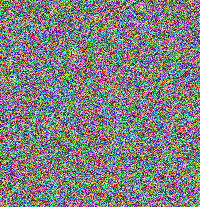

In [16]:
img_ofb = OFB(bits,key,iv)

img=np.array([bin2dec(b) for b in split_img(img_ofb,8)]).reshape(np.array(img).shape)
Image.fromarray(np.uint8(np.array(img)))

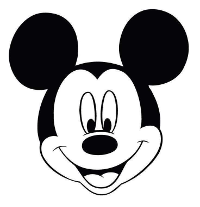

In [17]:
img_ofb_dec = OFB(img_ofb,key,iv)
img=np.array([bin2dec(b) for b in split_img(img_ofb_dec,8)]).reshape(np.array(img).shape)
Image.fromarray(np.uint8(np.array(img)))

## Zadanie 5 (1 pkt.)

Zaimmplementuj funkcję dodającą do wiadomości padding zgodnie z standardem PKCS#5. Wiadomości będą zapisywane w postaci tablicy bajtów zapisanych szesnastkowo. Funkcja ma przyjmować jako argumenty wiadomość oraz długość bloku do jakiego wiadomość ma być dopełniona.

In [18]:
def padding(msg, L):
    x = L - len(msg)%L
    return msg + ([f"{x:02X}"] * x)

In [19]:
print(padding(['ed', 'd2', '76', 'dc', '2b', 'd6', 'ff', 'a6', '35', '35', 'be', '1a', '26'],16) == 
              ['ed', 'd2', '76', 'dc', '2b', 'd6', 'ff', 'a6', '35', '35', 'be', '1a', '26', '03', '03', '03'])
print(padding(['54', '10', '38', 'c0', 'cc', 'e7', '8d', '8f', '70', '22'],16) == 
              ['54', '10', '38', 'c0', 'cc', 'e7', '8d', '8f', '70', '22', '06', '06', '06', '06', '06', '06'])
print(padding(['8e', 'ba', 'e3', 'd9', '76', '08', 'f1', 'd2', 'ca', '09', '39', '6b', 'b0', '4d', '36', '94', '49', '69', '30', '57', '3e', '9d', 'df', 'd7', 'fa', 'aa', '95', '5c', '60', '5f'],16) == 
              ['8e', 'ba', 'e3', 'd9', '76', '08', 'f1', 'd2', 'ca', '09', '39', '6b', 'b0', '4d', '36', '94', '49', '69', '30', '57', '3e', '9d', 'df', 'd7', 'fa', 'aa', '95', '5c', '60', '5f', '02', '02'])
print(padding(['1e', '17', '53', '69'],8)==
              ['1e', '17', '53', '69', '04', '04', '04', '04'])
print(padding(['42', 'f2', '07', 'c7', '32', 'd8', '10', '7e', 'a5', '53', '0d', '18'],8)==
              ['42', 'f2', '07', 'c7', '32', 'd8', '10', '7e', 'a5', '53', '0d', '18', '04', '04', '04', '04'])

True
True
True
True
True


## Zadanie 6 (2 pkt.)

Zaimplementuj wyrocznię, która sprawdza czy podana wiadomość ma prawidłowy padding i zwraca False lub True.

In [20]:
def oracle(msg, L):
    
    def correct_length():
        return len(msg) % L == 0

    def lastbyte():
        return int(msg[-1], 16)
    
    def correct_lastbyte():
        return 1 <= lastbyte() <= L
    
    def correct_padding():
        padded_bytes = msg[-lastbyte():]
        return all(padded_bytes[0] == p for p in padded_bytes)
    
    return correct_length() and correct_lastbyte() and correct_padding()
    

In [21]:
print(oracle(['ed', 'd2', '76', 'dc', '2b', 'd6', 'ff', 'a6', '35', '35', 'be', '1a', '26', '03', '03', '03'],16) == True)
print(oracle(['54', '10', '38', 'c0', 'cc', 'e7', '8d', '8f', '70', '22', 'aa', '06', '06', '06', '06', '06'],16) == False)
print(oracle(['8e', 'ba', 'e3', 'd9', '76', '08', 'f1', 'd2', 'ca', '09', '39', '6b', 'b0', '4d', '36', '94', '49', '69', '30', '57', '3e', '9d', 'df', 'd7', 'fa', 'aa', '95', '5c', '60', '5f', '02', '02'],16) == True)
print(oracle(['1e', '17', '53', '04', '04', '04', '04', '04'],8) == True)
print(oracle(['1e', '17', '53', '04', '04', '04', '04', '00'],8) == False)
print(oracle(['1e', '17', '53', '04', '04', '04', '04', 'aa'],8) == False)
print(oracle(['42', 'f2', '07', 'c7', '32', 'd8', '10', '7e', 'a5', '53', '0d', '18', '04', '04', '04', '04'],8) == True)
print(oracle(['42', 'f2', '07', 'c7', '32', 'd8', '10', '7e', 'a5', '53', '0d', '18', '04', '00', '04', '04'],8) == False)

True
True
True
True
True
True
True
True


## Zadanie 7 (2 pkt.)

Zmienna msg_enc zawiera zaszyfrowaną wiadomość, w trybie CBC, z wektorem inicjującym iv oraz nieznanym kluczem. Funkcja server przyjmuje zaszyfrowaną wiadomość, odszyfrowywuje ją i sprawdza padding zwracając czy jest on poprawny. Korzystając z wartości logicznych zwracanych przez tą funkcję (tylko z nich, zakładamy, że nie mamy dostępu do klucza zawertego w tej funkcji ani do wyniku deszyfracji), przeprowadź atak typu padding oracle i zdeszyfruj wiadomość.

In [63]:
msg_enc = ['be', '21', 'a2', 'd7', '9d', 'c7', '8d', 'a3']
iv = ['36', '92', '8b', '53', 'ef', 'f2', '7a', 'e4']

In [23]:
def msgbin_to_msghex(msg):
    return [format(int(a,2),'02x') for a in [msg[8*i:8*i+8] for i in range(8)]]

In [24]:
def msghex_to_msgbin(msg):
    return ''.join([format(int(i,16),'08b') for i in msg])

In [25]:
def server(msg_enc, iv):
    key = '0111101000001010110010000001010101111111100000000000101000110001'
    msg = CBCde(msghex_to_msgbin(msg_enc), key, msghex_to_msgbin(iv))
    return oracle(msgbin_to_msghex(msg),8)

In [26]:
def increment_hex(hex_str):
    inc = (int(hex_str, 16) + 1) % 256
    return f"{inc:02x}"

def alter_iv(iv, n_bytes):
    return [increment_hex(h) for h in iv[:n_bytes]] + iv[n_bytes:]

def increment_lastbytes(msg, n_bytes):
    return msg[:-n_bytes] + [increment_hex(h) for h in msg[-n_bytes:]]

In [67]:
msg_enc = ['be', '21', 'a2', 'd7', '9d', 'c7', '8d', 'a3']
iv = ['36', '92', '8b', '53', 'ef', 'f2', '7a', 'e4']

found_padding = False
L = len(msg_enc)

i = 0
while not found_padding:
    found_padding = not server(msg_enc, alter_iv(iv, i))
    if not found_padding:
        i = i + 1

idx = (L - i)        
print("iv     ", iv)
p_02 = ['00'] * i + ['02'] * idx
p_03 = ['00'] * i + ['03'] * idx
print("p2     ", p_02)
print("p3     ", p_03)

def xor_hex(h1, h2):
    def hex2dec(h):
        return int(h, 16)
    
    def dec2hex(d):
        return f"{d:02x}"
    
    def xor_dec(a, b):
        return a ^ b
    
    h1_dec = [hex2dec(h) for h in h1]
    h2_dec = [hex2dec(h) for h in h2]

    h1_xor_h2 = [xor_dec(*z) for z in list(zip(h1_dec, h2_dec))]
    return [dec2hex(h) for h in h1_xor_h2]



def check_server(msg, iv, padding):
    L = len(msg)
    
    def pad_word(w):
        return ['00'] * (L-padding) + [dec2hex(w)] * padding
    
    def dec2hex(d):
        return f"{d:02x}"
    
    pad_xored = xor_hex(pad_word(padding), pad_word(padding+1))
    print(msg)
    msg = msg[:(L-padding)] + [dec2hex(padding)] * padding
    print(msg)
    print(server(msg, iv))
    
server(msg_enc, iv)   
print(msg_enc)

temp = iv
temp[-2] = '7b'
temp[-1] = 'e5'
#temp[-3] = 'f3'

for i in range(255):
    x = f"{i:02x}"
    msg_enc[-3] = x
    if (server(msg_enc, temp)):
        print(i, server(msg_enc, temp))
    

print(msg_enc)
server(msg_enc, iv)

iv      ['36', '92', '8b', '53', 'ef', 'f2', '7a', 'e4']
p2      ['00', '00', '00', '00', '00', '00', '02', '02']
p3      ['00', '00', '00', '00', '00', '00', '03', '03']
['be', '21', 'a2', 'd7', '9d', 'c7', '8d', 'a3']
28 True
143 True
199 True
['be', '21', 'a2', 'd7', '9d', 'fe', '8d', 'a3']


False